# Monte Carlo Ferromagnet

Christina C Lee

Physics Prerequisites: Statistics Mechanics/ Phase Transitions

Numerics Prerequisite: Monte Carlo Markov Chain

## The physics

What process turns liquid water into a solid?  As temperature lowers, materials transition from a regime where the desire to maximize entropy dominates to desiring to minimize energy.   In transitions like liquid-solid, the energy arises from atom-atom forces.  This problem falls into a category called first order phase transitions, which are difficult to study.

Instead of looking at the liquid-solid problem to understand phase transitions, we will look at a magnetic material undergoing a second order phase transition. In our approximation of the problem, the atoms exist at fixed positions on a lattice, and interact with their neighbor according to the following Hamiltonian,
\begin{equation}
    {\cal H} = -J \sum_{<i,j>} S^z_i S_j^z
\end{equation}
, which is basically just the energy.  This <i>Ising</i> Model has nearest neighbors interacting, and each spin variablesolely points in the $\pm z$ direction.  

At a given temperature $T$ (inverse temperature $\beta=1/T$, $k_b=1$), the occupancy of a given configuration $c_i$ follows the Maxwell-Boltzmann Probability Distribution,
\begin{equation}
P(c_i)=\frac{\mathrm{e}^{-\beta E(c_i)}}{\sum\limits_j \mathrm{e}^{-\beta E(c_j)}}
\end{equation}
We need to determine observables given this probability distribution.

## The Numerics

In the post on the Markov Chain, each state was a location on our grid.  Now our state is one configuration of all our $N$ spins.  That means for an Ising spin we have $2^N$ different configurations.  Yeah... We aren't going to be exploring all of those.  

So how do we get from one state to the next? 

First, we choose a spin that we could flip.  This potential spin is chosen randomly for convenience's sake.  

Then we use the <b>Metropolis-Hastings Algorithm</b> to decide whether or no to flip the spin and generate a new configuration.  

We split the solution into two cases based on $\alpha = \frac{\pi_i}{\pi_j}= \frac{P(c_i)}{P(c_j)}$:

* If $\alpha > 1$ then always accept the transition, $p_{i \to j} = 1$
* If $\alpha < 1$, accept the transition with probability $\alpha = p_{i \to j}$

<b>Does this obey detailed balance? </b>

From the Monte Carlo Markov Chain post, we take our equation for detailed balance

\begin{equation}
\frac{p_{i \to j}}{ p_{j \to i}} = \frac{\pi_i}{\pi_j}
\end{equation}

How about ergodicity? We can reach any configuration by flipping spins.   

For the Ising Ferromagnet, our $\alpha$ is
\begin{equation}
\alpha= \frac{Z}{Z} \frac{\mathrm{e}^{-\beta E_i}}{\mathrm{e}^{-\beta E_j}} 
= \mathrm{e}^{\beta \left(E_j - E_i \right)}
\end{equation}
which is simply a function of difference in energy between two states.  Therefore we don't need to know the absolute energy at each point in time, just how the spin flip changes its local environment.  

## Tunable Parameters

I will say a little bit about the tunable parameters here, but Monte Carlo simulations are as much an art as a science, so I leave it up to you to play with the numbers and build intuition for what works.  

### Temperature

<img src="../images/Ferromagnet/couch1.JPG" width="200px" style="float: left; margin: 20px"/> <img src="../images/Ferromagnet/mountain.jpg" width="200px" style="float: right; margin: 20px"/>
On the left I am performing a low temperature search of a couch store.  I found a minimum, and even though I got stuck there, I thoroughly got to know what that minimum had to offer. On the right though, I'm performing a high temperature search of the Alexander Hills, Death Valley, California in pursuit of Neoproterzoic carbonates and dimictites.  I needed to be able to explore a lot more of the environment.  

While in a physical system like a magnet, temperature has a physical meaning, we can create other types of situations, like optimization or approximating a probability distribution, where we use temperature to describe how stuck we are to a particular minimum.  This intuition also plays a role in interpreting the results of of our simulation. 

Temperature can also provide other complications when we are studying critical phenomena, phase transitions.  Near the critical temperature, computations get much more difficult.  Elaboration in later post.

### Size of Lattice

* Larger lattice gives more precise results.
* Larger lattice takes more memory and time.  
* Finite Size effects (to be disscussed later) display some interesting physics.

### Coupling Constant J

Usually normalized out anyway...

### Number of time steps

Each Monte Carlo time step is one complete sweep of the lattice ($N$ random flip attempts).  The more time steps, the more accurate the results, but the longer you have to wait.

### When to Measure

Though a time step does include $N$ spin flips, that doesn't mean we have actually moved to a truly new configuration.  If we want to randomly sample our configuration space, we need to wait a bit longer to sample.  Too short a time, and our measurements are coupled and not accurate.  Too long, and we are wasting computations.  In a later post, I will look at the autocorrelation time, which is a good way to figure our if your measurement time is good.  

### Other potential Options

Some less important things: periodic versus open boundary conditions, shape and symmetries of simulation cell.

In [1]:
using PyPlot;
push!(LOAD_PATH,".")
using Lattices;

Instead of going into calculating all the lattice parameters again, we will use a class I define in the file Lattices.jl .  This class contains

Lattice Types
* Chain
* Square
* Honeycomb
You can edit the file to make your own types.

Once a lattice is created, it contains <b>Members of Type</b>:
* `name`, a string
* `l`, length in number of unit cells
* `dim`, dimension of lattice
* `a`, array containing the basis vectors by which positions are generated
* `unit`, array of positions inside a single unit
* `N`, number of total sites
* `X`, array of positions
* `nnei`, number of nearest neighbors
* `neigh`, Array of nearest neighbors [i][j], where i is site and j is 1:nnei

Today, I will just look at the square lattice, since that indicates much of the standard phase transition properties.  Some of the lattices I have shown (kagome, triangular, ...) are special frustrated lattices, and thus will behave very wierdly in this situation.

In [2]:
## Define l here
l=50;

lt=MakeLattice("Square",l);
S=ones(Int8,l,l);  #Our spins
dt=1/(lt.N);

In [3]:
# The energy contribution of just one site
function dE(i::Int)
    Eii=0;
    for j in 1:lt.nnei
        Eii+=S[lt.neigh[i,j]];
    end
    Eii*=-J*S[i];  # we are computing J sz_i sz_j for one i
    return Eii;
end
# The energy of the entire lattice
function E()
    Evar=0;
    for k in 1:lt.N
        Evar+=.5*dE(k);
    end
    return Evar;
end
# The magnetization of the entire lattice
function M()
    Mvar=0;
    for k in 1:lt.N
        Mvar+=S[k];
    end
    return Mvar;
end
"defined functions"

"defined functions"

# Adjustable Parameters

I have set up the simulation so that you can perform two different things.  For one, you can set `video=true` and `t` to a small variable.  Then in a new window you see what the configuration looks like each time you measure.  

Or you can set `video=false` and `t` to a large variable, and actually measure the statistics for the system over a bunch of configurations. 

In [7]:
beta=.7;
J=1;
t=100000;
video=false;
nskip=10;   # don't measure every sweep= better decorrelation
"Parameters set"

"Parameters set"

In [8]:
nmeas=Int64(t/nskip); # how many times we will measure
Ma=Array{Int32}(nmeas); # our magnetization measurements
Ea=Array{Int32}(nmeas); # our energy measurements
"done"

"done"

In [9]:
tm=1; #Our measurement time step
pygui(true)
for ti in 1:t
    for j in 1:lt.N
        i = rand(1:lt.N); #Choosing a random site
        de=dE(i);
        if(de>0 || rand()<exp(2*beta*de) ) 
            S[i]=-S[i]; #Switch the sign
        end
    end
    if isapprox(mod(ti,nskip),0)
        Ma[tm]=M();
        Ea[tm]=E();
        tm+=1;
        
        if video==true
            pygui(true)
            pcolor(S,cmap="winter")
            magnow=round(M()/lt.N,3)
            title("t: $ti  M: $magnow ")
            draw()
            sleep(.5)
            #nm=dec(ti,4)
            #savefig("Magnetimages2/pic_l50_bp7_$nm.png")
        end
    end
end
Mave=mean(Ma/lt.N);
Mstd=std(Ma/lt.N);
Eave=mean(Ea/lt.N);
Estd=std(Ea/lt.N);
Mave, Mstd

(0.9901423999999995,0.003369708850000745)

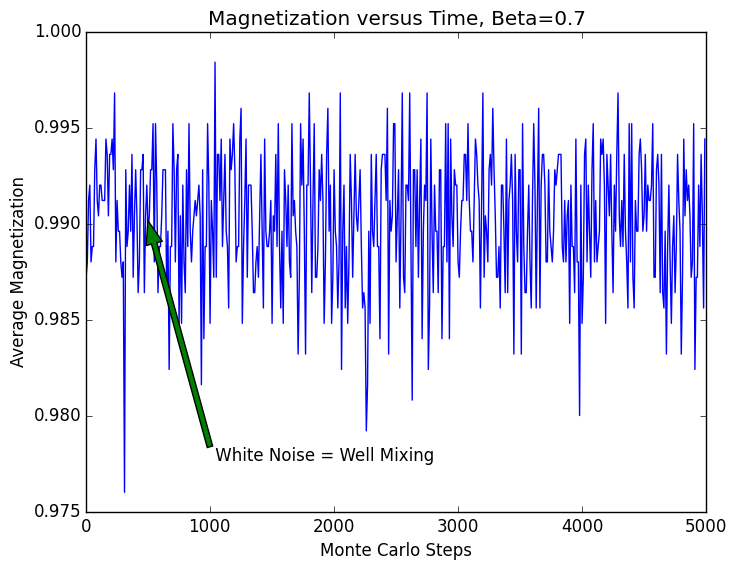

PyObject <matplotlib.text.Annotation object at 0x323bde590>

In [15]:
pygui(false)
title("Magnetization versus Time, Beta=$beta")
xlabel("Monte Carlo Steps")
ylabel("Average Magnetization")
plot(collect(1:10:5000),Ma[1:500]/lt.N)
annotate(" White Noise = Well Mixing",
xy=[500, Mave ],
xytext=[1000, Mave-.0125],
    xycoords="data",
    arrowprops=Dict("facecolor"=>"green"))

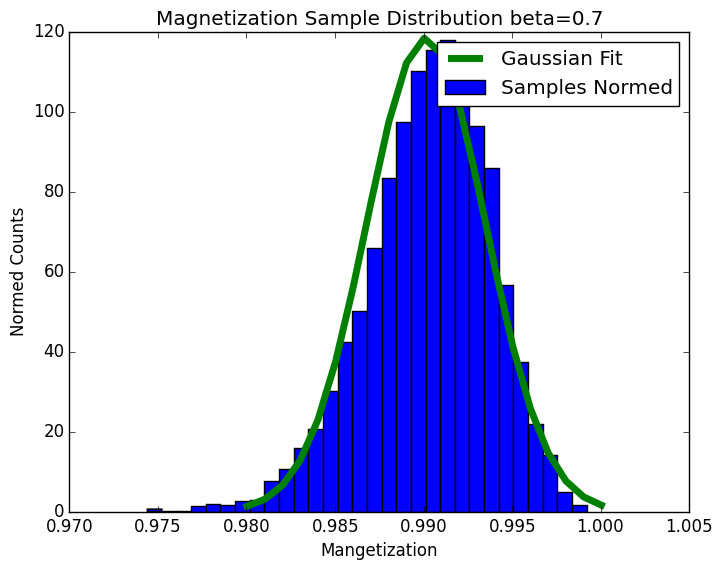

PyObject <matplotlib.legend.Legend object at 0x324456d10>

In [18]:
pygui(false)
plt[:hist](Ma/lt.N,bins=30,normed=true,label="Samples Normed");
x=collect(Mave-Mstd*3:.001:Mave+Mstd*3)
gaussian=1/(Mstd*sqrt(2*pi))*exp(-(x-Mave).^2/(2*Mstd^2));
plot(x,gaussian,linewidth=5,label="Gaussian Fit")
title("Magnetization Sample Distribution beta=$beta")
xlabel("Mangetization")
ylabel("Normed Counts")
legend(loc="upper right")
#savefig("Ferromagnet/maghist_bp3.png")

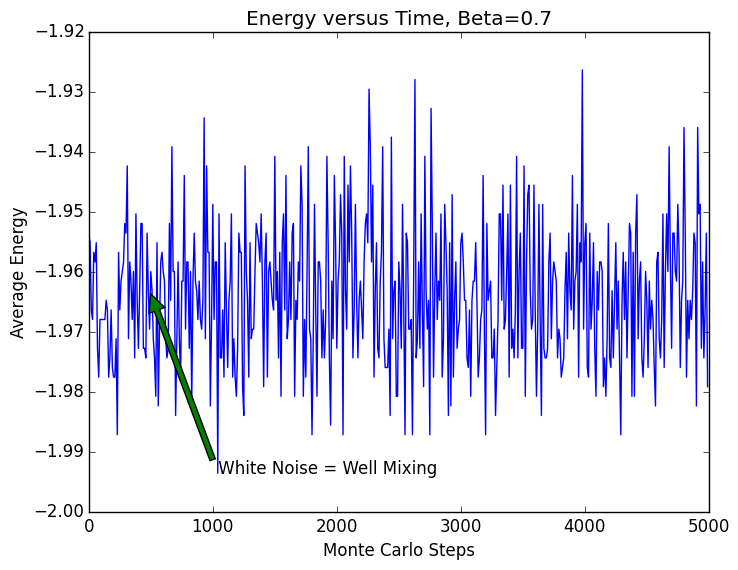

PyObject <matplotlib.text.Annotation object at 0x3252cd410>

In [23]:
pygui(false)
title("Energy versus Time, Beta=$beta")
xlabel("Monte Carlo Steps")
ylabel("Average Energy")
plot(collect(1:10:5000),Ea[1:500]/lt.N)
annotate(" White Noise = Well Mixing",
    xy=[500, Eave ],
xytext=[1000, Eave-.03],
   xycoords="data",
   arrowprops=Dict("facecolor"=>"green"))

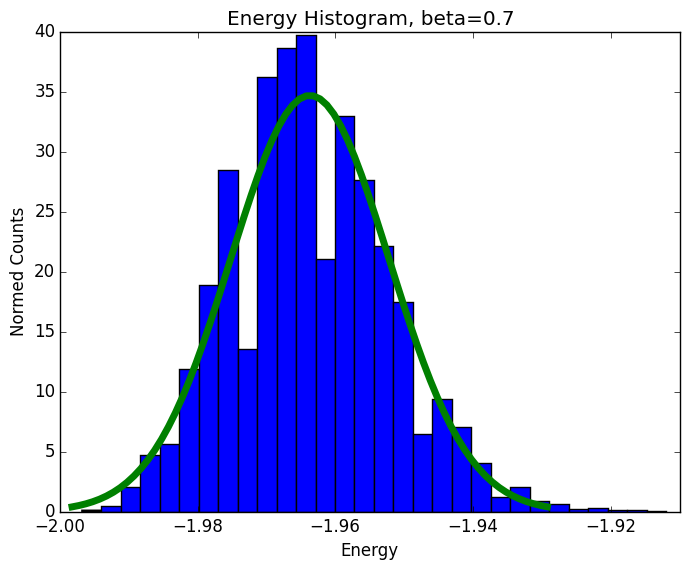

PyObject <matplotlib.text.Text object at 0x325828890>

In [26]:
pygui(false)
plt[:hist](Ea/lt.N,bins=30,normed=true,label="Samples Normed");
x=collect(Eave-3*Estd:.001:Eave+3*Estd)
gaussian=1/(Estd*sqrt(2*pi))*exp(-(x-Eave).^2/(2*Estd^2));
plot(x,gaussian,linewidth=5,label="Gaussian Fit")
title("Energy Histogram, beta=$beta")
xlabel("Energy")
ylabel("Normed Counts")
#savefig("Ferromagnet/Ehist_bp3.png")

# Example Results
So here are some example results I got.


Paramagnet Gif
![paramagnet gif](../images/Ferromagnet/ParamagnetL30_b2.gif)

Paramagnet Magnetization Samples.  A properly tuned simulations should be showing white noise without correlations or getting stuck in particular areas.  
![magnetization](../images/Ferromagnet/mt.png)

Histogram for Magnetization, $\beta=0.3$

![Magnetization Histogram](../images/Ferromagnet/maghist_bp3.png)

Histogram for Energy $\beta=0.3$

![Energy Histogram](../images/Ferromagnet/Ehist_bp3.png)

Magnet at $\beta=0.7$ Gif
![Magnet](../images/Ferromagnet/Magnet_betap7.gif)

Histogram for Magnetization

![Magnetization Histogram](../images/Ferromagnet/maghist_bp7.png)

Histogram for Energy

![Energy Histogram](../images/Ferromagnet/Ehist_bp7.png)

# To be covered later:

This is an extremely rich problem.  Since this post seems long enough for me already, I'll leave these to exercises for you right now, or you can wait until I hold your hand through them.  

* Plot magnetization and energy as a function of temperature
* What's the transition temperature?
* How does the dispersion change as a function of temperature? Use that to calculate specific heat and susceptibility
* How do results change with system size?  
* Change dimension?
* Put it on a different lattice.  BE CAREFUL of lattices like triangular, checkerboard, pyrochlore, ...
* Ferromagnetic versus Antiferromagnetic coupling
* Autocorrelation function
* Structure Factor (Fourier transform) 
